# XGBOOST로 전력소비량 예측

## Load Library

In [1]:
# Import Module
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import xgboost
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

c:\Users\kijeong\anaconda3\envs\ml\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# Fixed random seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## Load Data

In [3]:
# Load Data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
building = pd.read_csv('./data/building_info.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
# train
display(train.head())
train.info()
train.shape

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


(204000, 10)

In [5]:
# test
display(test.head())
test.info()
test.shape

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


(16800, 7)

In [6]:
# building
display(building.head())
building.info()
building.shape

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


(100, 7)

In [7]:
# 건물유형 값 영어로 변경
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building['건물유형'] = building['건물유형'].replace(translation_dict)

In [8]:
# Merge data
# 건물번호를 기준으로 train, test data와 building data merge
train_df = train.copy()
test_df = test.copy()

train_df = pd.merge(train_df, building, on='건물번호')
test_df = pd.merge(test_df, building, on='건물번호')

In [9]:
# Drop the unnecessary columns for analysis
train_df.drop(columns=['num_date_time', '일조(hr)', '일사(MJ/m2)'], inplace=True)
test_df.drop(columns=['num_date_time'], inplace=True)

In [10]:
# Rename columns
train_df.columns = ['building_num', 'date', 'temperature', 'precipitation', 'windspeed', 'humidity', 'power_consumption',
                    'building_type', 'total_area', 'cooling_area', 'solar', 'ess', 'pcs']
test_df.columns = ['building_num', 'date', 'temperature', 'precipitation', 'windspeed', 'humidity',
                    'building_type', 'total_area', 'cooling_area', 'solar', 'ess', 'pcs']

## Data Preprocessing

In [11]:
# Process the missing values of precipitation
train_df['precipitation'].fillna(0, inplace=True) # 강수량은 0으로 채움

In [12]:
# Process the missing values of wind speed and humidity
def fill_missing_with_avg(df, columns):
    for i in range(len(df)):
        if pd.isna(df.loc[i, columns]):
            prev_value = df.loc[i-1, columns]
            next_value = df.loc[i+1, columns]
            avg_value = (prev_value + next_value) / 2
            if pd.isna(prev_value) or pd.isna(next_value):
                building_num = df.loc[i,:]['building_num']
                date = df.loc[i,:]['date'][:8]
                avg_value = df[(df['building_num'] == building_num) & (df['date'].str.contains(date))][columns].mean()

            df.loc[i, columns] = avg_value

fill_missing_with_avg(train_df, 'windspeed')
fill_missing_with_avg(train_df, 'humidity')

In [13]:
# Convert the type of date from object to datetime
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%d %H')

In [14]:
# Decomposition of time elements
train_df['month'] = train_df.date.dt.month
train_df['day'] = train_df.date.dt.day
train_df['weekday'] = train_df.date.dt.weekday
train_df['hour'] = train_df.date.dt.hour
train_df['weekend'] = train_df['weekday'].isin([5,6]).astype(bool)
train_df['date'] = train_df.date.dt.date

In [15]:
# Process the missing values of solar, ESS, PCS
# -을 0으로 대체
train_df[['solar', 'ess', 'pcs']] = train_df[['solar', 'ess', 'pcs']].replace('-', 0)
train_df[['solar', 'ess', 'pcs']] = train_df[['solar', 'ess', 'pcs']].astype(float)

In [16]:
# Add time periodic columns
month_periodic = (train_df['month'] - 1) / 12 # 1부터 시작하므로 1을 빼줌
day_periodic = (train_df['day'] - 1) / 31 # 1부터 시작하므로 1을 빼줌
weekday_periodic = train_df['weekday'] / 7
hour_periodic = train_df['hour'] / 24

def sin_transform(values):
    return np.sin(2 * np.pi * values)
def cos_transform(values):
    return np.cos(2 * np.pi * values)

train_df['sin_month'] = sin_transform(month_periodic)
train_df['cos_month'] = cos_transform(month_periodic)
train_df['sin_day'] = sin_transform(day_periodic)
train_df['cos_day'] = cos_transform(day_periodic)
train_df['sin_weekday'] = sin_transform(weekday_periodic)
train_df['cos_weekday'] = cos_transform(weekday_periodic)
train_df['sin_hour'] = sin_transform(hour_periodic)
train_df['cos_hour'] = cos_transform(hour_periodic)

In [17]:
pd.to_datetime('2022-06-01')

Timestamp('2022-06-01 00:00:00')

In [18]:
train_df.date[0]

datetime.date(2022, 6, 1)

In [19]:
# Add holiday column
# holiday = 1, workday = 0
train_df['holiday'] = train_df.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
train_df.loc[(train_df.date == datetime.date(2022, 6, 1))&(train_df.date == datetime.date(2022, 8, 15)), 'holiday'] = 1

In [20]:
# Add DI column (DI : Discomfort Index (불쾌지수))
train_df['DI'] = 9/5*train_df['temperature'] - 0.55*(1 - train_df['humidity']/100) * (9/5*train_df['humidity'] - 26) + 32

In [21]:
# Add CDH column (CDH : Cooling Degree-Day)
# CDD(냉방도일) -> CDH(냉방도시)로 데이터에 맞게 변형한 개념
# 냉방도일 : 어느 지방의 더운 정도를 나타내는 지표로 사용 (sum(해당 일의 기온 - 기준온도))
# 냉방도일이 크면 연료의 소비량이 많아짐
# 실내온도가 같아도 외부 기온은 지역별로 다름 -> 지역마다 값이 다르게 나타남 -> 이 데이터에서는 건물별로 다르다고 얘기할 수 있음
# 냉방도시 : sum(해당 시간의 기온 - 기준온도)
def CDH(df, num_building):
    df_ = df.copy()
    cdhs = np.array([])
    for num in range(1, num_building+1, 1):
        cdh = []
        cdh_df = df_[df_['building_num'] == num_building]
        cdh_temp = cdh_df['temperature'].values # Series로도 돌릴 수 있지만 array로 돌리는게 속도가 훨씬 빠름
        for i in range(len(cdh_temp)):
            if i < 11:
                cdh.append(np.sum(cdh_temp[:(i+1)] - 26))
            else:
                cdh.append(np.sum(cdh_temp[(i-11):(i+1)] - 26))
        
        cdhs = np.concatenate([cdhs, cdh])
    
    return cdhs

train_df['CDH'] = CDH(train_df, 100)

## Modeling

In [22]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [23]:
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [24]:
train_df.hour

0          0
1          1
2          2
3          3
4          4
          ..
203995    19
203996    20
203997    21
203998    22
203999    23
Name: hour, Length: 204000, dtype: int64

train data shape
x:(187200, 25), y:(187200,)


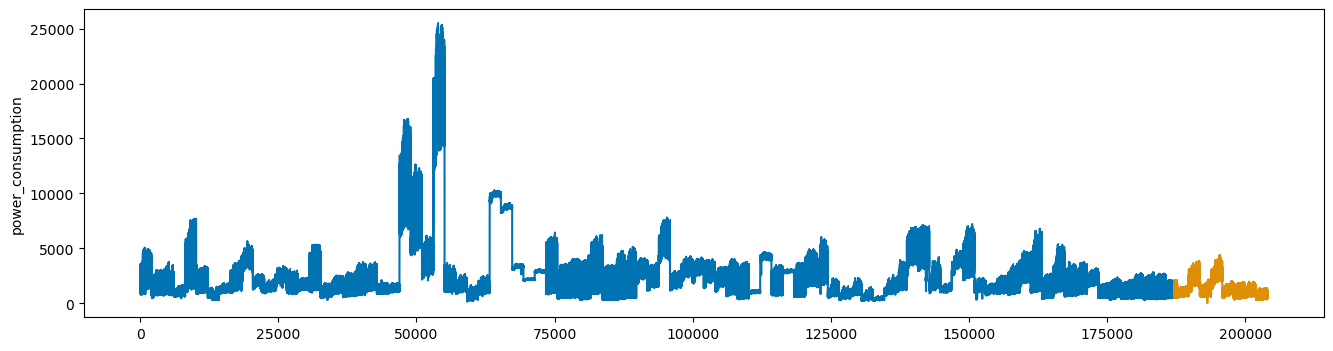

In [71]:
y = train_df.loc[:, 'power_consumption']
x = train_df.loc[:, :].drop(columns=['building_num', 'date', 'power_consumption', 'building_type'])

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 16800) # 24시간*7일 = 168

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [72]:
xgb_reg = XGBRegressor(n_estimators = 10000, seed=42,
                       min_child_weight = 1, eta = 0.3,
                       gamma = 0, max_depth = 6, 
                       colsample_bytree = 1, subsample = 1)

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

best iterations: 1
SMAPE : 28.773897694239086


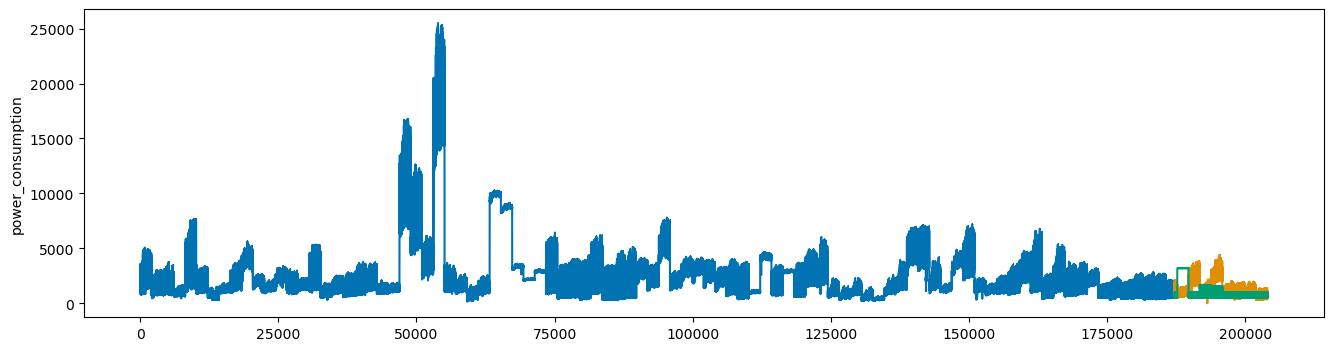

In [79]:
# yellow : true, green : pred
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

In [28]:
'''
xgb_reg = XGBRegressor(n_estimators = 10000, seed=42,
                       min_child_weight = 1, eta = 0.3,
                       gamma = 0, max_depth = 6, 
                       colsample_bytree = 1, subsample = 1)

xgb_reg.set_params(**{'objective':weighted_mse(100)})

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
'''

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             objective=<function weighted_mse.<locals>.weighted_mse_fixed at 0x0000021A4B7B7CA0>, ...)

best iterations: 1
SMAPE : 10.226923497082275


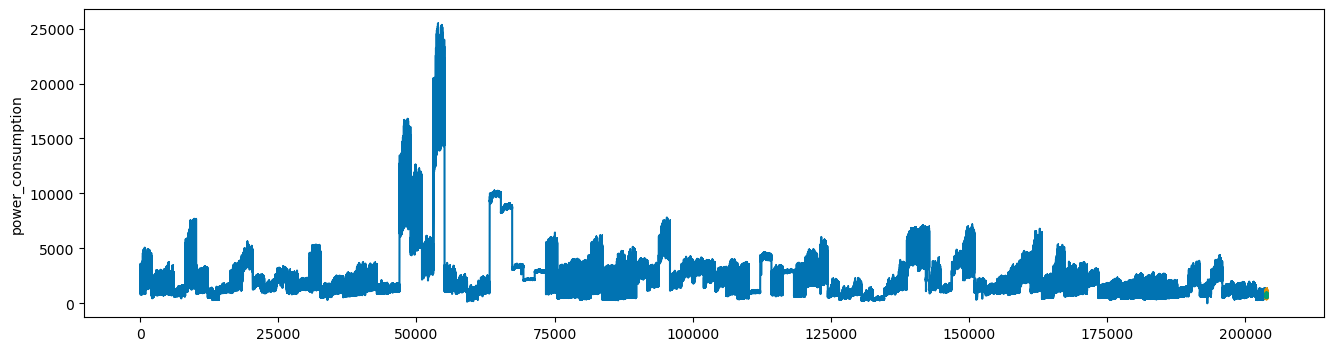

In [29]:
'''
## SMAPE 값으로도, 그래프 상으로도 과소추정이 모델이 개선되었음을 확인
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))
'''

## Prediction

In [74]:
# Process the missing values of precipitation
test_df['precipitation'].fillna(0, inplace=True) # 강수량은 0으로 채움

In [31]:
# Process the missing values of wind speed and humidity
def fill_missing_with_avg(df, columns):
    for i in range(len(df)):
        if pd.isna(df.loc[i, columns]):
            prev_value = df.loc[i-1, columns]
            next_value = df.loc[i+1, columns]
            avg_value = (prev_value + next_value) / 2
            if pd.isna(prev_value) or pd.isna(next_value):
                building_num = df.loc[i,:]['building_num']
                date = df.loc[i,:]['date'][:8]
                avg_value = df[(df['building_num'] == building_num) & (df['date'].str.contains(date))][columns].mean()

            df.loc[i, columns] = avg_value

fill_missing_with_avg(train_df, 'windspeed')
fill_missing_with_avg(train_df, 'humidity')

In [32]:
# Convert the type of date from object to datetime
test_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%d %H')

In [33]:
# Decomposition of time elements
test_df['month'] = test_df.date.dt.month
test_df['day'] = test_df.date.dt.day
test_df['weekday'] = test_df.date.dt.weekday
test_df['hour'] = test_df.date.dt.hour
test_df['weekend'] = test_df['weekday'].isin([5,6]).astype(bool)
test_df['date'] = test_df.date.dt.date

In [34]:
# Process the missing values of solar, ESS, PCS
# -을 0으로 대체
test_df[['solar', 'ess', 'pcs']] = test_df[['solar', 'ess', 'pcs']].replace('-', 0)
test_df[['solar', 'ess', 'pcs']] = test_df[['solar', 'ess', 'pcs']].astype(float)

In [35]:
# Add time periodic columns
month_periodic = (test_df['month'] - 1) / 12 # 1부터 시작하므로 1을 빼줌
day_periodic = (test_df['day'] - 1) / 31 # 1부터 시작하므로 1을 빼줌
weekday_periodic = test_df['weekday'] / 7
hour_periodic = test_df['hour'] / 24

def sin_transform(values):
    return np.sin(2 * np.pi * values)
def cos_transform(values):
    return np.cos(2 * np.pi * values)

test_df['sin_month'] = sin_transform(month_periodic)
test_df['cos_month'] = cos_transform(month_periodic)
test_df['sin_day'] = sin_transform(day_periodic)
test_df['cos_day'] = cos_transform(day_periodic)
test_df['sin_weekday'] = sin_transform(weekday_periodic)
test_df['cos_weekday'] = cos_transform(weekday_periodic)
test_df['sin_hour'] = sin_transform(hour_periodic)
test_df['cos_hour'] = cos_transform(hour_periodic)

In [36]:
# Add holiday column
# holiday = 1, workday = 0
test_df['holiday'] = test_df.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
test_df.loc[(test_df.date == datetime.date(2022, 6, 1))&(test_df.date == datetime.date(2022, 8, 15)), 'holiday'] = 1

In [37]:
# Add DI column (DI : Discomfort Index (불쾌지수))
test_df['DI'] = 9/5*test_df['temperature'] - 0.55*(1 - test_df['humidity']/100) * (9/5*test_df['humidity'] - 26) + 32

In [38]:
# Add CDH column (CDH : Cooling Degree-Day)
# CDD(냉방도일) -> CDH(냉방도시)로 데이터에 맞게 변형한 개념
# 냉방도일 : 어느 지방의 더운 정도를 나타내는 지표로 사용 (sum(해당 일의 기온 - 기준온도))
# 냉방도일이 크면 연료의 소비량이 많아짐
# 실내온도가 같아도 외부 기온은 지역별로 다름 -> 지역마다 값이 다르게 나타남 -> 이 데이터에서는 건물별로 다르다고 얘기할 수 있음
# 냉방도시 : sum(해당 시간의 기온 - 기준온도)
def CDH(df, num_building):
    df_ = df.copy()
    cdhs = np.array([])
    for num in range(1, num_building+1, 1):
        cdh = []
        cdh_df = df_[df_['building_num'] == num_building]
        cdh_temp = cdh_df['temperature'].values # Series로도 돌릴 수 있지만 array로 돌리는게 속도가 훨씬 빠름
        for i in range(len(cdh_temp)):
            if i < 11:
                cdh.append(np.sum(cdh_temp[:(i+1)] - 26))
            else:
                cdh.append(np.sum(cdh_temp[(i-11):(i+1)] - 26))
        
        cdhs = np.concatenate([cdhs, cdh])
    
    return cdhs

test_df['CDH'] = CDH(test_df, 100)

In [49]:
x_test = test_df.drop(columns=['building_num', 'date', 'building_type'])

In [81]:
test_pred = xgb_reg.predict(x_test)

In [82]:
sample_submission['answer'] = test_pred

In [83]:
sample_submission.to_csv('xgb1.csv', index=False)

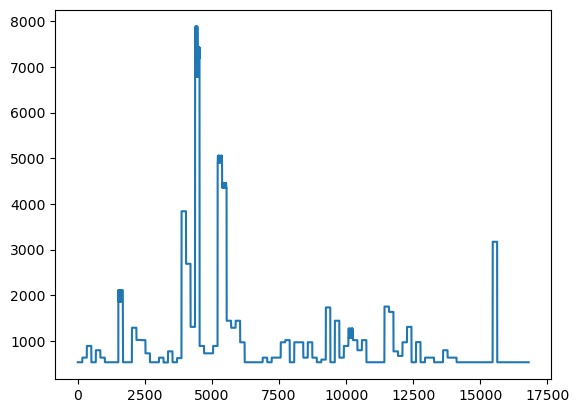

In [84]:
plt.plot(test_pred)